# Word Count with MapReduce - Lab

## Introduction

Now that we have seen the key map and reduce operators in Spark, and also know when to use transformation and action operators, we can revisit the word count problem we introduced earlier in the section. In this lab, we will read a text corpus into the Spark environment, perform a word count, and try basic NLP ideas to get a good grip on how MapReduce performs. 

## Objectives

In this lab you will:

* Apply the map(func) transformation to a given function on all elements of an RDD in different partitions 
* Apply a map transformation for all elements of an RDD 
* Compare the difference between a transformation and an action within RDDs 
* Use collect(), count(), and take() actions to trigger spark transformations 
* Use filter to select data that meets certain specifications within an RDD 
* Use Spark and the MapReduce framework to complete a full parallelized word count problem 

## Word Count Task

Here is what our problem looks like:

* We have a huge text document
* We need to count the number of times each distinct word appears in the document

Sample applications:

* Analyze web server logs to find popular URLs
* Analyze texts for content or style 

## Word Count with MapReduce

We will illustrate a MapReduce computation for counting the number of occurrences for each word in a text corpus. 

In this example, the data consists of a directory `text/` containing `.txt` documents. These documents each contain the full text of a work by either William Shakespeare or Jane Austen.

In our analysis we'll count the frequency of words for __style identification__ as word frequencies might have unique features which can potentially describe the author's writing style. We'll walk through the steps one by one, then write a function at the end that allows us to compare the different authors.

MapReduce in PySpark provides a practical and efficient way of achieving this goal as it: 

* works if the file is too large for memory,
* works even if the output is too large for memory, and
* is naturally parallelizable


### MapReduce Framework

Here are the steps that we will perform for our problem, under the MapReduce framework:  

1. Sequentially read a lot of data
   * From a text file in this case
2. **Split:** Split the data into chunks that can be analyzed separately
   * In this case, each line of the text file becomes a record in an RDD
3. **Map:** Perform any relevant transformations
   * We'll be splitting each line into words, making the words lowercase, and removing punctuation
4. **Shuffle:** Group by key in preparation for reducing
   * In this case, we want to group by the cleaned word
   * Spark does this for us automatically; we just need to invoke the Reduce step
5. **Reduce:** Aggregate, summarize, filter, or sort
   * We'll aggregate the frequencies, filter by frequency as well as by specific stopwords, and end by sorting by frequency
6. Write the result
   * Our final result will be a list of tuples containing the top 10 words and their frequencies

As a reminder, here is what it looks like visually, given the example we used before:
![](./images/MapReduceZooExample.drawio.png)

### Initialize SparkContext

- First, import the `pyspark` module into this Python environment and initialize a SparkContext with the conventional name `sc`
- SparkContext should be local (standalone cluster)

In [1]:
# Start a local SparkContext
import pyspark
sc = pyspark.SparkContext('local[*]','word count')


To test our code, start with a single text file, `'hamlet.txt'`. First, set a file path variable `file` to the location of `'text/hamlet.txt'`. 

In [3]:
# Set a path variable for data 
file = 'text/hamlet.txt'
file
# 'text/hamlet.txt'

'text/hamlet.txt'

## Read and Split Text File Contents into RDD - `sc.textFile()`

Previously we used parallelization to read an RDD from a Python list. Here we'll read the text file into Spark RDDs by using the `sc.textFile()` method. We'll load the data from the text file into an RDD called `lines`. 

The documentation the `textFile` method in PySpark can be found [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.SparkContext.textFile.html) and more in-depth documentation on RDDs can be found [here](https://spark.apache.org/docs/latest/rdd-programming-guide.html).

The `textFile(path)` method reads a text file from the HDFS/local file system/any Hadoop supported file system, into the number of partitions specified and returns it as an RDD of strings.

In [5]:
# Read the text file into an RDD using sc.textFile()
lines = sc.textFile(file)
lines
# text/hamlet.txt MapPartitionsRDD[36] at textFile at NativeMethodAccessorImpl.java:0

text/hamlet.txt MapPartitionsRDD[3] at textFile at <unknown>:0

The text file has been written in a "line-by-line" manner into the RDD. We can access any given entry using simple indexing. 

In order to view the contents of the RDD, we will use the `RDD.collect()` method since calling the RDD by name will not return the contents, only the object type and relevant information due to lazy loading. 

Print a few sample lines from the `lines` RDD.

In [ ]:
# Code here


Similarly, we can also print the whole document line by line if we loop over the result of `collect()`.

Print the complete Hamlet from the `lines` RDD.

In [7]:
# Print the text, line-by-line
# This will output the whole of hamlet text, one line at a time. 
print(lines.collect()[500])
print(lines.collect()[1000])

    But even then the morning cock crew loud,
  Ham. Indeed, upon my sword, indeed.


Great, now that the complete text file is in a `lines` RDD, we can easily use the map function to break it down further into individual words and parallelize it accordingly. 

__Note: Parallelization is handled by the Spark environment according to available infrastructure and doesn't need any further configuration__.

## The Map Step

Currently we have an RDD where each record is a line of text. What we need to do next is:

* Split each line into words
  * We might call these `w1, w2, . . . , wn`
* Clean up the words based on any issues we notice
* Map the words onto a tuple containing the word and the number `1`
  * The tuples will look like this: `(w1, 1), (w2, 1), . . . ,(wn, 1)`

Then later on we will use the Reduce step to combine all of those numbers into word counts.

### Spark Mapping Functions

Previously, we saw that:

* `map(func)` returns a new distributed dataset formed by passing each element of the source through a function `func`.
* `flatMap(func)` maps each input item to 0 or more output items (so `func` should return a seq rather than a single item).
* `flatMap()` breaks the output of a lambda function into individual RDD elements (as opposed to map).


### Split Each Line into Words

* Use `RDD.flatMap()` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.flatMap.html)) to split the lines by whitespace and collect into one flat RDD.
* The transformation is defined in the lambda expression, where the input `x` is defined as producing the result of `x.split()`.
* Use the `RDD.take(n)` method ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.take.html)) to pick `10` words from the top of the sequence, in order to view the results of our work so far.

In [11]:
# split the lines into words based on whitespace and show ten elements from the top 
words = lines.flatMap(lambda x: x.split())
words.take(10)
# Code here 


# ['1604',
#  'THE',
#  'TRAGEDY',
#  'OF',
#  'HAMLET,',
#  'PRINCE',
#  'OF',
#  'DENMARK',
#  'by',
#  'William']

['1604',
 'THE',
 'TRAGEDY',
 'OF',
 'HAMLET,',
 'PRINCE',
 'OF',
 'DENMARK',
 'by',
 'William']


### Create a Tuple of (Word, 1)

* Map each word to a tuple of (word, 1), which will be our (key, value) pair later on.
  * (Yes, just the number 1 for each word. Eventually this numbers will be added together.)
* Use `RDD.map` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.map.html))
* Use `RDD.take(n)` to view 10 elements

In [14]:
# Use a lambda function with map to add a 1 to each word and output a tuple
# (word, 1) - Take ten elements
tuples = words.map(lambda x: (x,1))
tuples.take(10)
# Code here

# [('1604', 1),
#  ('THE', 1),
#  ('TRAGEDY', 1),
#  ('OF', 1),
#  ('HAMLET,', 1),
#  ('PRINCE', 1),
#  ('OF', 1),
#  ('DENMARK', 1),
#  ('by', 1),
#  ('William', 1)]

[('1604', 1),
 ('THE', 1),
 ('TRAGEDY', 1),
 ('OF', 1),
 ('HAMLET,', 1),
 ('PRINCE', 1),
 ('OF', 1),
 ('DENMARK', 1),
 ('by', 1),
 ('William', 1)]

Looking at the counts above, do you notice anything that might cause a problem?

It appears that we have a mixture of words in capital letters as well as lowercase letters. If we count this way, `"THE"` and `"the"` would be considered two separate words due to case sensitivity.

### Cleaning: Normalize Case

One typical way to normalize different cases in strings is just to make them all lowercase.

Modify the map function above to change all the words to lowercase using a `.lower()` inside the lambda function. Then use `RDD.take(n)` to view 10 elements.

In [15]:
# Change the words in words tuples to lowercase - take 10 elements 
tuples_lowercase = words.map(lambda x:(x.lower(),1))
tuples_lowercase.take(10)
# Code here

# [('1604', 1),
#  ('the', 1),
#  ('tragedy', 1),
#  ('of', 1),
#  ('hamlet,', 1),
#  ('prince', 1),
#  ('of', 1),
#  ('denmark', 1),
#  ('by', 1),
#  ('william', 1)]

[('1604', 1),
 ('the', 1),
 ('tragedy', 1),
 ('of', 1),
 ('hamlet,', 1),
 ('prince', 1),
 ('of', 1),
 ('denmark', 1),
 ('by', 1),
 ('william', 1)]

## The Reduce Step

Ok, now we think we have data that is prepared for the next step.

### Aggregate Word Counts

Our goal is to aggregate all of those `1`s to find the word count.

The Reduce step's argument is a pair consisting of a key and its list of associated values as the pairs created above. The output of the Reduce function is a sequence of zero or more key-value pairs. These key-value pairs can be of a type different from those sent from Map tasks to Reduce tasks, but often they are the same type.

We will refer to the application of the Reduce step to a single key and its associated list of values as a reducer.

* Use `RDD.reduceByKey()` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.reduceByKey.html)) to add up all the words.
* For this method, the lambda has two arguments (`x` and `y`) instead of just `x`. `x` will be the word and `y` will be the count.
* The new (key, value) pairs would have the word as a key and the number of occurrences as a value. 


In [39]:
# Use reduceByKey with lowercase tuples to add all values under same keys - take 10
word_count=tuples_lowercase.reduceByKey(lambda x,y: x+y)
word_count.take(10)

# Code here 


# [('1604', 1),
#  ('tragedy', 1),
#  ('of', 670),
#  ('prince', 2),
#  ('denmark', 10),
#  ('shakespeare', 1),
#  ('dramatis', 1),
#  ('claudius,', 2),
#  ('king', 43),
#  ('officer.', 3)]

[('1604', 1),
 ('tragedy', 1),
 ('of', 670),
 ('prince', 2),
 ('denmark', 10),
 ('shakespeare', 1),
 ('dramatis', 1),
 ('claudius,', 2),
 ('king', 43),
 ('officer.', 3)]

Hmm, there is still something off about this data. Specifically, we have some words containing punctuation, so that `"officer"` and `"officer."` are treated as different words.

### Cleaning: Remove Punctuation

Let's go back to the cleaning step (Map), then Reduce again so that the duplicates are grouped together.

Apply another `.map` to our aggregated data so that the words are stripped of punctuation. Currently when we write `lambda x:` that `x` contains a (word, count) tuple, so make sure you apply the string transformation to `x[0]` and return a tuple containing the transformed string as well as `x[1]`.

In other words, if `x` is `('officer.', 3)` then your lambda function should return `('officer', 3)`.

***Hint:*** in case you don't remember, this is an example of how you would remove punctuation from a single string:

```python
import string
'claudius,'.strip(string.punctuation)
# 'claudius'
```

In [22]:
# Change the words in word count tuples to remove punctuation - take 10
import string
punc_removed=word_count.map(lambda x: (x[0].strip(string.punctuation),x[1]))
punc_removed.take(10)
# Code here

# [('1604', 1),
#  ('tragedy', 1),
#  ('of', 670),
#  ('prince', 2),
#  ('denmark', 10),
#  ('shakespeare', 1),
#  ('dramatis', 1),
#  ('claudius', 2),
#  ('king', 43),
#  ('officer', 3)]

[('1604', 1),
 ('tragedy', 1),
 ('of', 670),
 ('prince', 2),
 ('denmark', 10),
 ('shakespeare', 1),
 ('dramatis', 1),
 ('claudius', 2),
 ('king', 43),
 ('officer', 3)]

### Aggregate Word Counts Again

Presumably we have some duplicate words again now that punctuation has been removed. Use `reduceByKey` again to aggregate their counts.

In [24]:
# Reduce again using words with puctuation removed - take 10
word_count = punc_removed.reduceByKey(lambda x,y: x+y)
word_count.take(10)
# Code here

# [('1604', 1),
#  ('tragedy', 3),
#  ('of', 675),
#  ('prince', 5),
#  ('denmark', 23),
#  ('shakespeare', 1),
#  ('dramatis', 1),
#  ('king', 196),
#  ('officer', 3),
#  ('son', 22)]

[('1604', 1),
 ('tragedy', 3),
 ('of', 675),
 ('prince', 5),
 ('denmark', 23),
 ('shakespeare', 1),
 ('dramatis', 1),
 ('king', 196),
 ('officer', 3),
 ('son', 22)]

### Filter Rare Words

Now we are going beyond just getting a word count, into the other kinds of Map steps that can occur.

In addition to aggregating, the Map step can also be used for filtering.

Let's use `RDD.filter(func)` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.filter.html)) to remove all words that appear less frequently than some threshold value.

* `func` in this case is a lambda function that takes in `x` (a tuple of (word, count)) and returns True or False.
  * In this case, `x[1]` is what you care about, since it contains the word count
* `func` should return True if we want to keep the word and False if we want to filter it out.
* Let's say for this task you want to filter out any word that appears less than `5` times.
  * This NLP approach can be useful to identify common topics between documents, where very rare words can be misleading.

In [28]:
# Remove all rare words with frequency less than 5 - take 10 
freq_words = word_count.filter(lambda x: x[1]>=5)
freq_words.take(10)

# Code here 

# [('of', 675),
#  ('prince', 5),
#  ('denmark', 23),
#  ('king', 196),
#  ('son', 22),
#  ('polonius', 36),
#  ('horatio', 47),
#  ('courtier', 10),
#  ('guildenstern', 30),
#  ('gentleman', 16)]

[('of', 675),
 ('prince', 5),
 ('denmark', 23),
 ('king', 196),
 ('son', 22),
 ('polonius', 36),
 ('horatio', 47),
 ('courtier', 10),
 ('guildenstern', 30),
 ('gentleman', 16)]

### Filter to Keep Only Stopwords

Add a filtering step to retain only words included in a list of stopwords.

For this task, the stopwords are:

```python
['the','a','in','of','on','at','for','by','I','you','me']
```

Once again, use the `filter` function and pass in a lambda function. This time you want to use `x[0]` (the word) in your conditional statement.

In [58]:
# Filter to keep only stopwords
stopword_list = ['the','a','in','of','on','at','for','by','i','you','me']
stopwords = freq_words.filter(lambda x: x[0] in stopword_list)
stopwords.collect()
# Code here 

# [('of', 675),
#  ('at', 87),
#  ('i', 577),
#  ('in', 434),
#  ('you', 554),
#  ('me', 234),
#  ('for', 250),
#  ('on', 128),
#  ('the', 1090),
#  ('by', 111),
#  ('a', 558)]

[('of', 675),
 ('at', 87),
 ('i', 577),
 ('in', 434),
 ('you', 554),
 ('me', 234),
 ('for', 250),
 ('on', 128),
 ('the', 1090),
 ('by', 111),
 ('a', 558)]

### Filter to Remove Stopwords

Modify the filter operation above to keep all the words found in the text **except** the stop words. 

Removing stop words can be useful in recognizing the topic of a document.

In [34]:
# Modify above filter to remove stopwords
stopword_list = ['the','a','in','of','on','at','for','by','I','you','me']
keep_words = freq_words.filter(lambda x: x[0] not in stopword_list)
keep_words.take(10)
# Code here 

# [('prince', 5),
#  ('denmark', 23),
#  ('king', 196),
#  ('son', 22),
#  ('polonius', 36),
#  ('horatio', 47),
#  ('courtier', 10),
#  ('guildenstern', 30),
#  ('gentleman', 16),
#  ('two', 26)]

[('prince', 5),
 ('denmark', 23),
 ('king', 196),
 ('son', 22),
 ('polonius', 36),
 ('horatio', 47),
 ('courtier', 10),
 ('guildenstern', 30),
 ('gentleman', 16),
 ('two', 26)]

### Find the Top 10

Now that we have an RDD containing only keep words (i.e. containing no stopwords), use `RDD.takeOrdered` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.takeOrdered.html)) to take the top 10 key-value pairs by word frequency.

You'll need to use the `key` argument in order to sort by the count, and also use `-x[1]` to order by highest to lowest

In [40]:
# Take top 10 key-value pairs by frequency
output = keep_words.takeOrdered(10, lambda x: -x[1])
output
# Code here

# [('and', 964),
#  ('to', 742),
#  ('my', 520),
#  ('it', 419),
#  ('that', 389),
#  ('ham', 358),
#  ('is', 346),
#  ('not', 315),
#  ('his', 304),
#  ('this', 300)]

[('and', 964),
 ('to', 742),
 ('i', 577),
 ('my', 520),
 ('it', 419),
 ('that', 389),
 ('ham', 358),
 ('is', 346),
 ('not', 315),
 ('his', 304)]

## Putting It All Together 

Combine the above code as a function called `top_10_words` that splits, cleans, combines, and filters the words in a text file before returning the 10 most frequent words and their frequencies.

Then pass in three works of Shakespeare (`'romeandjuliet.txt'`, `'hamlet.txt'`, and `'othello.txt'`) and observe the results. Repeat the same exercise for three works of Jane Austen (`'senseandsensibility.txt'`, `'prideandprejudice.txt'` and `'emma.txt'`). 

> Can you recognize the writing styles or topics of these authors based on their word frequencies?

> What can you do to improve the author recognition ability?

In [59]:
# Create a function for word count that takes in a file name and stop wordlist to perform above tasks
def top_10_words(sc, file_name, stopword_list):
    
    # Load from file on disk into RDD
    lines = sc.textFile(file_name)
    
    # Split into words
    words = lines.flatMap(lambda x : x.split())
    
    # Clean word tuples (lowercase and remove punctuation all at once this time)
    clean_tuples = words.map(lambda x: (x.lower().strip(string.punctuation),1))
    
    # Reduce to get word counts
    word_count= clean_tuples.reduceByKey(lambda x,y:x+y)
    
    # Filter out words that appear fewer than 5 times
    # (this is not really needed for this task, but could help improve
    # efficiency in some contexts)
    freq_words = word_count.filter(lambda x: x[1]>=5)
    
    
    # Filter out words in stopword_list
    final_wc = freq_words.filter(lambda x: x[0] not in stopword_list)
    
    # Return the top 10
    return final_wc.takeOrdered(10, lambda x: -x[1])

In [60]:
# Test out the function with Shakespeare texts

# Code here 
print(top_10_words(sc, 'text/romeoandjuliet.txt', stopword_list))
print(top_10_words(sc, 'text/hamlet.txt', stopword_list))
print(top_10_words(sc, 'text/othello.txt', stopword_list))


[('and', 754), ('to', 625), ('my', 378), ('is', 371), ('that', 361), ('thou', 277), ('not', 274), ('this', 270), ('with', 255), ('it', 254)]
[('and', 964), ('to', 742), ('my', 520), ('it', 419), ('that', 389), ('ham', 358), ('is', 346), ('not', 315), ('his', 304), ('this', 300)]
[('and', 825), ('to', 663), ('my', 452), ('that', 389), ('it', 343), ('iago', 341), ('not', 334), ('is', 319), ('this', 276), ('your', 237)]


In [61]:
# Test out the function with Austen texts
print(top_10_words(sc, 'text/senseandsensibility.txt', stopword_list))
print(top_10_words(sc, 'text/prideandprejudice.txt', stopword_list))
print(top_10_words(sc, 'text/emma.txt', stopword_list))
# Code here


[('to', 4228), ('and', 3601), ('her', 2563), ('was', 1871), ('it', 1768), ('she', 1610), ('that', 1415), ('be', 1319), ('not', 1275), ('as', 1248)]
[('to', 4204), ('and', 3593), ('her', 2211), ('was', 1847), ('she', 1694), ('that', 1586), ('it', 1519), ('not', 1444), ('he', 1323), ('his', 1269)]
[('to', 5202), ('and', 4535), ('was', 2367), ('her', 2356), ('it', 2244), ('she', 2207), ('not', 2108), ('be', 1970), ('that', 1715), ('he', 1697)]


In [ ]:
# Writing styles interpretation

"""
shakespere has thou, which is an older word.
Shakesperes most common words are very general and and can fit in most sentences while the other autour is has a lot more words like "she"

""";

## Level Up (Optional)

* Create histograms of the top 10 words from each author

In [62]:
import seaborn as sns


In [69]:
l = top_10_words(sc, 'text/romeoandjuliet.txt', stopword_list)


C:\Users\aplante\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

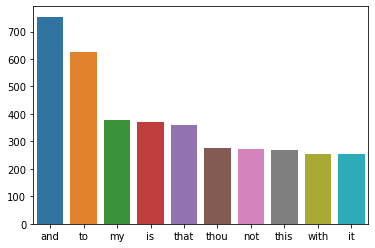

In [70]:
labels = [i[0] for i in l]
freq = [i[1] for i in l]
sns.barplot(labels, freq)

## Stop the SparkContext

In [71]:
sc.stop()

## Summary 

In this exercise, we saw MapReduce in action for solving a basic NLP task, i.e. counting the frequency of stop words and keep words of a text corpus. This exercise can be seen as a first step towards text analytics on big data platforms. After this lab, we will get into more advanced use cases of PySpark, specifically for machine learning applications. 